## Testing the atm MACHI correction of HYPSO 1 pictures, from the git of jgarrett

### imports

In [ ]:
from hypso import Hypso1, Hypso2
import os 
import sys
import matplotlib.pyplot as plt
from global_land_mask import globe 
import numpy as np 

parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import funcions_autonom as f
import atmosperic_correction as atm_c ## obs denne het før ac -> kan føre til feil dersom man ikke finner funkjsons navn
import base as ac

import xarray as xr
import re
import math
import importlib

from sklearn.cluster import KMeans
from collections import defaultdict

np.random.seed(42)

dir_path = ".." ## filene hentes fra en mappe over der vi er nå

In [17]:
fro_230330 = os.path.join(dir_path, "frohavet_2023-03-30T10-30-26Z-l1a.nc")
fro_230330_b = os.path.join(dir_path, "frohavet_2023-03-30T10-30-26Z-l1b.nc")
fro_230330_c = os.path.join(dir_path, "frohavet_2023-03-30T10-30-26Z-l1c.nc")
fro_230330_d = os.path.join(dir_path, "frohavet_2023-03-30T10-30-26Z-l1d.nc")

satobj_h1_230330 = Hypso1( path = fro_230330, verbose = True )

l1a_cube_230330 = satobj_h1_230330.l1a_cube
l1b_cube_230330 = Hypso1( path = fro_230330_b, verbose = True )
l1c_cube_230330 = Hypso1( path = fro_230330_c, verbose = True )
l1d_cube_230330 = Hypso1( path = fro_230330_d, verbose = True )

l1c_cube_230330 = l1c_cube_230330.l1c_cube
l1b_cube_230330 = l1b_cube_230330.l1b_cube
l1d_cube_230330 = l1d_cube_230330.l1d_cube

satobj_h1_230330.run_direct_georeferencing() # in order to get the longiyudes and latitudes

[INFO] Loading L1a capture frohavet_2023-03-30T10-30-26Z
[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide
[INFO] Loading L1b capture frohavet_2023-03-30T10-30-26Z
[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide
[INFO] Loading L1c capture frohavet_2023-03-30T10-30-26Z
[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide
[INFO] Loading L1d capture frohavet_2023-03-30T10-30-26Z
[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide
[INFO] Running direct georeferencing...
[INFO] ADCS samples: 1921
[INFO] ADCS time range: 1680171540.000000 to 1680172458.250000
[INFO] Frame time range: 1680172226.731407 to 1680172276.481407
[INFO] 199 sample(s) inside frame time range
[INFO] Interpolating 598 frames
[INFO] Computing pixel latitude and longitude coordinates ...
[INFO] Interpolating pixel coordinate gaps...
[INFO] Direct georeferencing done
[INFO] Running track geometry comput

### following the demo file

In [ ]:
#extract wanted waelengths
wl = satobj_h1_230330.wavelengths[4:118]
x_123 = [387.84749685, 391.40406599, 394.95941579, 398.51354623, 402.06645732, 405.61814905, 409.16862143, 412.71787446, 416.26590814, 419.81272246, 423.35831743, 426.90269305, 430.44584931, 433.98778622, 437.52850378, 441.06800198, 444.60628083, 448.14334033, 451.67918047, 455.21380126, 458.7472027, 462.27938479, 465.81034752, 469.3400909 , 472.86861492,476.3959196 , 479.92200491, 483.44687088, 486.97051749, 490.49294475,494.01415266, 497.53414122, 501.05291042, 504.57046026, 508.08679076,511.6019019 , 515.11579369, 518.62846612, 522.13991921, 525.65015294,529.15916731, 532.66696233, 536.173538  , 539.67889432, 543.18303128,546.68594889, 550.18764715, 553.68812606, 557.18738561, 560.68542581,564.18224665, 567.67784814, 571.17223028, 574.66539307, 578.1573365, 581.64806058, 585.1375653 , 588.62585068, 592.1129167 , 595.59876336,599.08339068, 602.56679864, 606.04898725, 609.5299565 , 613.0097064 ,616.48823695, 619.96554815, 623.44163999, 626.91651248, 630.39016561,633.86259939, 637.33381382, 640.8038089 , 644.27258462, 647.74014099,651.20647801, 654.67159568, 658.13549399, 661.59817294, 665.05963255,668.5198728 , 671.9788937 , 675.43669524, 678.89327744, 682.34864028,685.80278376, 689.25570789, 692.70741267, 696.1578981 , 699.60716418,703.0552109 , 706.50203826, 709.94764628, 713.39203494, 716.83520425,720.2771542 , 723.7178848 , 727.15739605, 730.59568795, 734.03276049,737.46861368, 740.90324752, 744.336662  , 747.76885713, 751.19983291,754.62958933, 758.0581264 , 761.48544412, 764.91154248, 768.33642149,771.76008115, 775.18252146, 778.60374241, 782.02374401, 785.44252625,788.86008915, 792.27643269, 795.69155687, 799.10546171, 802.51814719]
wl = x_123[4:118]

In [ ]:
#toa reflectence
cube = np.array(l1d_cube_230330[:,:, 4:118]) # get the toa reflectance cube

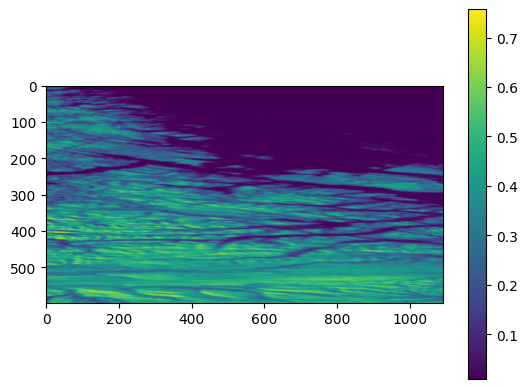

In [72]:
#plot of toa reflectance image 
plt.imshow(cube[:,:,100])
plt.colorbar()

In [ ]:
#identifying saturated pixels. Saturated meeans that the pixel value is above a certain threshold, which indicates that the sensor has reached its maximum capacity for that pixel. 
# aka without, as bright replecation of that pixel than can be shown. 
sat = np.max(l1a_cube_230330, axis = -1) > 35000 ## om feil, kan vøre feil akse her siden cuben er hentet på en anna måte

In [74]:
#Calculatiting Transmission and scattering coeficcent for the image, the printouts of this function should be decreasing.
importlib.reload(ac)
T, S, objs = ac.atm_correction(cube.reshape(-1,114), solar=np.ones(114), verbose = True, tol = 0.01, est_min_R = 0.05)

0.0035676612324148167
0.001245527125829396
0.0006724815614877414
0.0005202119703314721
0.00045535308963129975
0.0004240978869840134
0.00040827547054184295
0.0003999482628148956
0.00039519252738591325
0.00039218518750474787


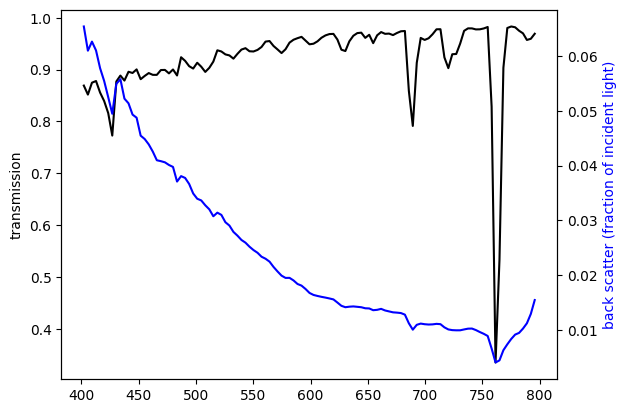

In [75]:
# plot the transmission and scattering vectors
fig, ax = plt.subplots(1)
ax.plot(wl,T, color='black')
ax.set_ylabel("transmission")
ax0 = ax.twinx()
ax0.set_ylabel("back scatter (fraction of incident light)", color='blue')
ax0.plot(wl,S, color='blue')

## disse eer like uavhengige av bilde som plottes, identiske med grafene fra demo fila!!!!!

In [76]:
#nomralizing the cube
cube_norm = (cube - S) /T
cube_norm[sat] = np.nan

print("cube_norm shape: ", cube_norm.shape)

cube_norm shape:  (598, 1092, 114)


[402.06645732, 405.61814905, 409.16862143, 412.71787446, 416.26590814, 419.81272246, 423.35831743, 426.90269305, 430.44584931, 433.98778622, 437.52850378, 441.06800198, 444.60628083, 448.14334033, 451.67918047, 455.21380126, 458.7472027, 462.27938479, 465.81034752, 469.3400909, 472.86861492, 476.3959196, 479.92200491, 483.44687088, 486.97051749, 490.49294475, 494.01415266, 497.53414122, 501.05291042, 504.57046026, 508.08679076, 511.6019019, 515.11579369, 518.62846612, 522.13991921, 525.65015294, 529.15916731, 532.66696233, 536.173538, 539.67889432, 543.18303128, 546.68594889, 550.18764715, 553.68812606, 557.18738561, 560.68542581, 564.18224665, 567.67784814, 571.17223028, 574.66539307, 578.1573365, 581.64806058, 585.1375653, 588.62585068, 592.1129167, 595.59876336, 599.08339068, 602.56679864, 606.04898725, 609.5299565, 613.0097064, 616.48823695, 619.96554815, 623.44163999, 626.91651248, 630.39016561, 633.86259939, 637.33381382, 640.8038089, 644.27258462, 647.74014099, 651.20647801, 654

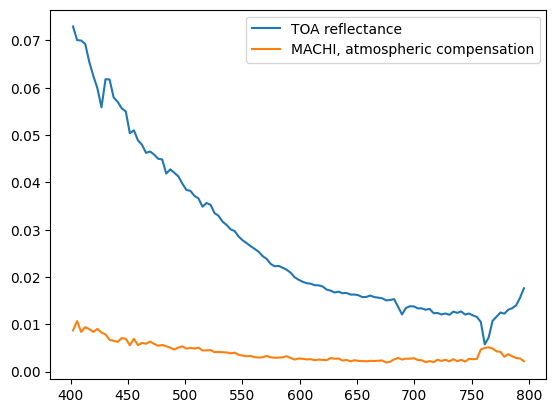

In [83]:
# compare a water pixel before and after atmospheric compensation
plt.plot(wl, cube[121,629], label = 'TOA reflectance') ## uten atm korreksjon
plt.plot(wl, cube_norm[121,629], label = 'MACHI, atmospheric compensation') ## med atm korreksjon --> funkeeer !!! wehooooo !!!!! DENNE SOM JEG ER UTE ETTER
plt.legend()

print(wl)

print(cube_norm[400,600])

In [78]:
# plot the RGB representation of the whole image ## tror dette er etter atm korreksjon, siden de bruker cube_norm
rgb = np.zeros(cube_norm.shape[:2] + (3,))

In [79]:
rgb[:,:,0] = cube_norm[:,:,65]
rgb[:,:,1] = cube_norm[:,:,47]
rgb[:,:,2] = cube_norm[:,:,20]
rgb*=20
rgb[rgb>1] =1
rgb[np.isnan(rgb)]=1

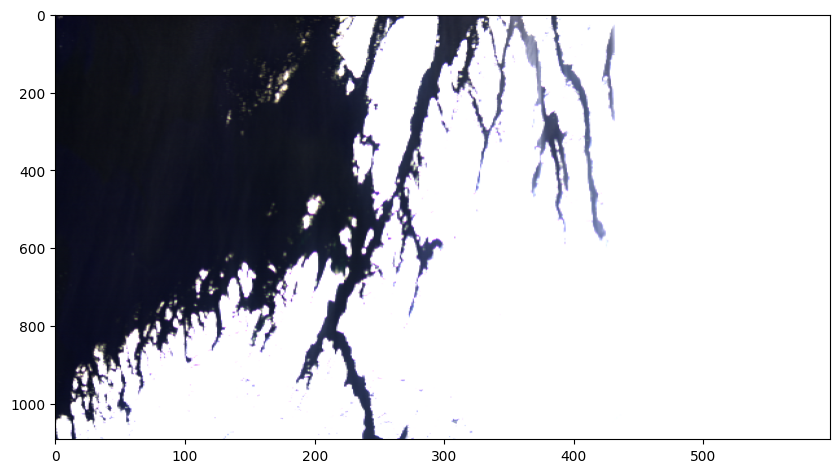

In [80]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.imshow(np.rot90(rgb), aspect=0.3)

In [81]:
satobj_h1_230330.create_geotiff(product="L1C", force_reload=False)

AttributeError: 'Hypso1' object has no attribute 'create_geotiff'